In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob


PATH_TO_DATA = '/home/lgierz/BA_MothClassification/data/'
PATH_TO_CA = PATH_TO_DATA + 'confidence_analysis/'

model_names = ["Linear Classifier", "KNN"]
fm_names = ['resnet', 'dino']

dataset_configs = {
    'top277': (277, [3000, 2000, 1000, 500]),
    'top387': (387, [2000, 1000, 500]),
    'top589': (589, [1000, 500])
}


PATH_TO_IMAGES = '/mnt/data/lgierz/moth_dataset_top589_max3000/'
PATH_TO_LABELS = PATH_TO_DATA + 'processed/dataset_top589_max3000.csv'
PATH_TO_CORRECTED_CONFS = PATH_TO_CA + 'results/all_results_corrected_labels_w_scores.csv'

labels_csv = pd.read_csv(PATH_TO_LABELS)
confidences_csv = pd.read_csv(PATH_TO_CORRECTED_CONFS)

# create real mapping for labels_csv
species = labels_csv['scientificName']
unique_species = sorted(species.unique())
species_mapping = {species: idx for idx, species in enumerate(unique_species)}

print(unique_species)
print(species_mapping)
print(len(unique_species))

['Abraxas grossulariata', 'Abraxas sylvata', 'Abrostola triplasia', 'Acasis viretata', 'Acentria ephemerella', 'Acleris forsskaleana', 'Acleris notana/ferrugana', 'Acleris variegana', 'Acontia lucida', 'Acontia trabealis', 'Acrobasis advenella', 'Acrobasis repandana', 'Acrobasis tumidana', 'Acronicta aceris', 'Acronicta leporina', 'Acronicta rumicis', 'Acronicta tridens / psi', 'Adela reaumurella', 'Adscita statices', 'Aethalura punctulata', 'Agapeta hamana', 'Agapeta zoegana', 'Aglais io', 'Aglais urticae', 'Aglossa pinguinalis', 'Agonopterix arenella', 'Agonopterix heracliana / ciliella', 'Agriopis aurantiaria', 'Agriopis leucophaearia', 'Agriopis marginaria', 'Agriphila geniculea', 'Agriphila inquinatella', 'Agriphila selasella', 'Agriphila straminella', 'Agriphila tristella', 'Agrius convolvuli', 'Agrochola circellaris', 'Agrochola lota', 'Agrochola lunosa', 'Agrochola lychnidis', 'Agrochola macilenta', 'Agrotis clavis', 'Agrotis exclamationis', 'Agrotis ipsilon', 'Agrotis puta', '

In [32]:

def show_sample_by_id(gbifid, conf_csv):

    # Find the image file
    image_files = glob.glob(PATH_TO_IMAGES + f"{gbifid}_*.jpg")
    if not image_files:
        print(f"No image found for GBIF ID {gbifid}")
        return
    
    image_path = image_files[0]
    image = plt.imread(image_path)

    info_text = ""

    rows = conf_csv[conf_csv['GbifID'] == gbifid]

    for idx, row in rows.iterrows():
    
        # serach in labels csv for the scientific name
        accuracy = row['Accuracy']
        species = row['Species']
        samples = row['Samples']
        fm = row['FoundationalModel']
        model = row['Model']
        species_num = row['Label']
        species_str = list(species_mapping.keys())[species_num]
        predicted_species_num = row['PredictedLabel']
        predicted_species_str = list(species_mapping.keys())[predicted_species_num]
        confidences = [(i,round(x, 4)) for i,x in eval(row['Confidence'])[0:5]]

        info_text += f"top{species}max{samples} / {fm.upper()}-{model} / Accuracy: {round(accuracy*100, 2)}%\n" \
            f"GbifID: {gbifid} | Filename: {image_path.split('/')[-1]}\n" \
            f"Labeled: {species_num}, {species_str}\n" \
            f"Predicted: {predicted_species_num}, {predicted_species_str}\n" \
            f"confidences: {confidences}\n\n"

        # print(f'Confidences for top{species}max{samples} / {fm.upper()}-{model}:')
        # print(confidences) 

    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')  # Turn off the axis

    # Adding the text box
    props = dict(boxstyle='square', facecolor='lightblue', alpha=0.5)
    plt.text(1.03, 0.8, info_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=props)

    plt.show()
    plt.pause(0.001)  

def get_gbifids_for_class(class_num, conf_csv, count=5):
    return list(conf_csv[conf_csv['Label'] == class_num]['GbifID'].head(count))




In [35]:
get_gbifids_for_class(256, confidences_csv, 3)

[4883241740, 4891379765, 4883139980]

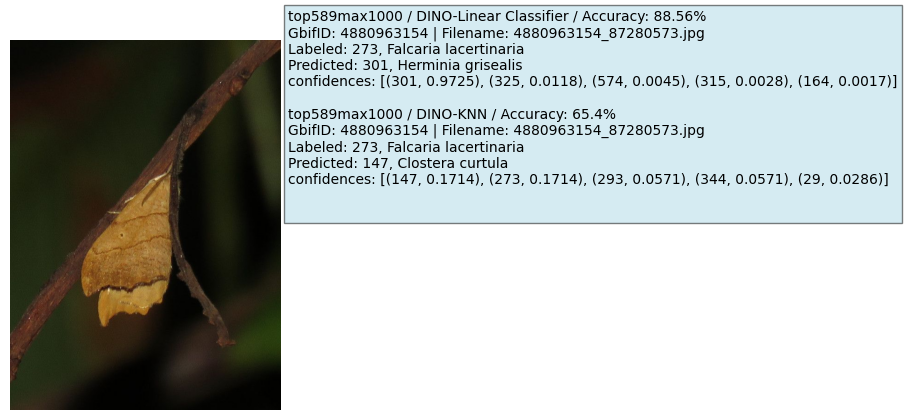

In [3]:
show_sample_by_id(4880963154, confidences_csv)

### Amount of samples which share the same gbifid

In [4]:
counts = list(confidences_csv['GbifID'].value_counts().values)
print('GbifIDs, Amount of Samples')
for x in range(1,33):
    a = counts.count(x)
    if a != 0:
        print(x,'\t', a)

GbifIDs, Amount of Samples
2 	 1171
4 	 374590
6 	 331
8 	 122863
10 	 99
12 	 41276
14 	 24
16 	 11603
18 	 1
20 	 2572
24 	 411
28 	 50
32 	 3


In [5]:
# print# Get the GbifIDs that occur x times
times = 2
amount = 5
gbifids_x_times = confidences_csv['GbifID'].value_counts()[confidences_csv['GbifID'].value_counts() == times].index[:amount]
print(f"Three GbifIDs that occur {times} times in the dataset: {gbifids_x_times.values}")



Three GbifIDs that occur 2 times in the dataset: [4880963154 4882612333 4888126657 3824185656 1963127705]


##### Prep columns for mean Confidences

In [6]:
confidences_csv['Top1_Confidence'] = confidences_csv['Confidence'].apply(lambda x: eval(x)[0][1])

In [7]:
confidences_csv['Top2_Confidence'] = confidences_csv['Confidence'].apply(lambda x: eval(x)[1][1])

In [8]:
confidences_csv['Confidence_Gap'] = confidences_csv['Top1_Confidence'] - confidences_csv['Top2_Confidence']

### Mean Top-1 Confidence

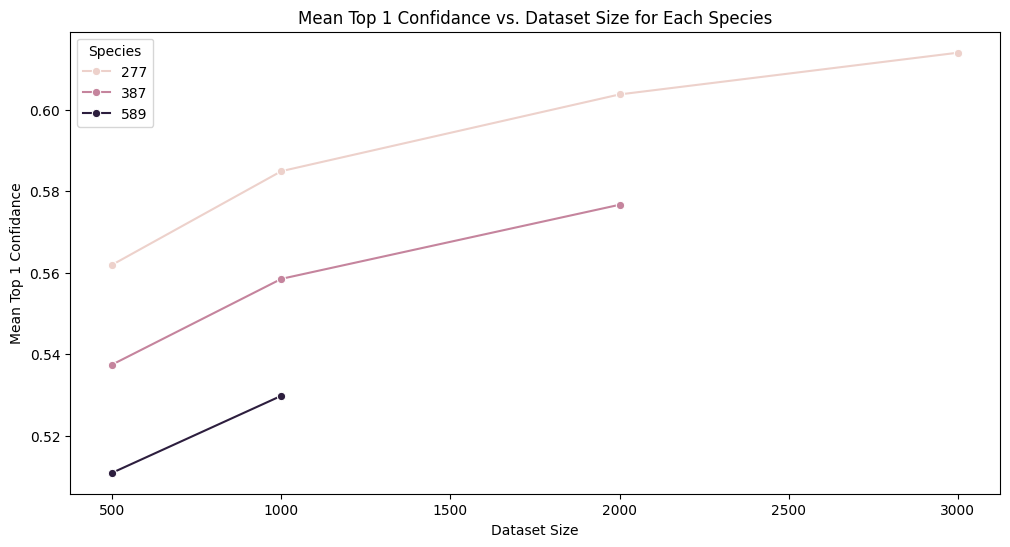

Species  Samples  Top1_Confidence
0      277     3000         0.613934
1      277     2000         0.603705
2      277     1000         0.584884
3      387     2000         0.576642
4      277      500         0.561934
5      387     1000         0.558468
6      387      500         0.537457
7      589     1000         0.529795
8      589      500         0.510915

In [9]:
mean_top1_confidences = confidences_csv.groupby(['Species', 'Samples'])['Top1_Confidence'].mean().reset_index()

# Plot species and sample size vs. mean confidence gap
plt.figure(figsize=(12, 6))
sns.lineplot(x='Samples', y='Top1_Confidence', hue='Species', data=mean_top1_confidences, marker='o')
plt.title('Mean Top 1 Confidance vs. Dataset Size for Each Species')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Top 1 Confidance')
plt.legend(title='Species')
plt.show()

mean_top1_confidences.sort_values(by='Top1_Confidence',ascending=False).reset_index(drop=True)


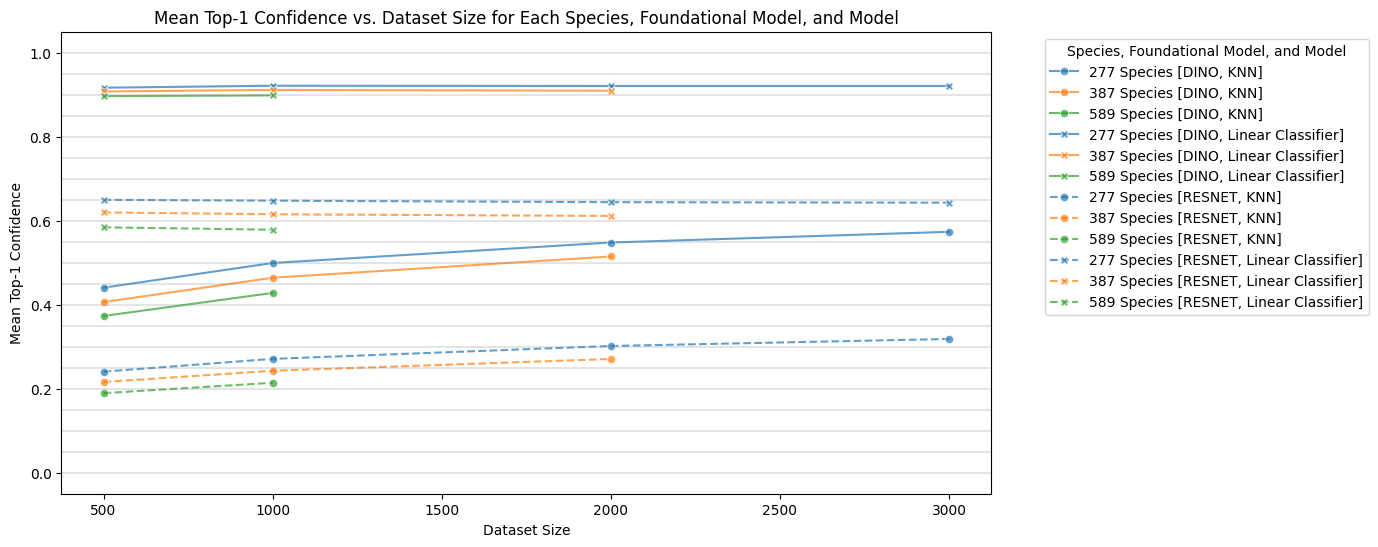

Species  Samples FoundationalModel              Model  Top1_Confidence
0       277     1000              dino  Linear Classifier         0.921419
1       277     2000              dino  Linear Classifier         0.920811
2       277     3000              dino  Linear Classifier         0.920786
3       277      500              dino  Linear Classifier         0.916725
4       387     1000              dino  Linear Classifier         0.911429
5       387     2000              dino  Linear Classifier         0.909554
6       387      500              dino  Linear Classifier         0.907767
7       589     1000              dino  Linear Classifier         0.898425
8       589      500              dino  Linear Classifier         0.896617
9       277      500            resnet  Linear Classifier         0.649747
10      277     1000            resnet  Linear Classifier         0.647726
11      277     2000            resnet  Linear Classifier         0.644190
12      277     3000            resnet  Linear Classifier         0.642920
13      387      500            resnet  Linear Classifier         0.619761
14      387     1000            resnet  Linear Classifier         0.615446
15      387     2000            resnet  Linear Classifier         0.611329
16      589      500            resnet  Linear Classifier         0.584266
17      589     1000            resnet  Linear Classifier         0.578554
18      277     3000              dino                KNN         0.573569
19      277     2000              dino                KNN         0.548096
20      387     2000              dino                KNN         0.514848
21      277     1000              dino                KNN         0.499347
22      387     1000              dino                KNN         0.464213
23      277      500              dino                KNN         0.440566
24      589     1000              dino                KNN         0.428086
25      387      500              dino                KNN         0.406317
26      589      500              dino                KNN         0.373272
27      277     3000            resnet                KNN         0.318461
28      277     2000            resnet                KNN         0.301722
29      277     1000            resnet                KNN         0.271046
30      387     2000            resnet                KNN         0.270838
31      387     1000            resnet                KNN         0.242786
32      277      500            resnet                KNN         0.240699
33      387      500            resnet                KNN         0.215982
34      589     1000            resnet                KNN         0.214114
35      589      500            resnet                KNN         0.189505

In [10]:
import warnings

warnings.filterwarnings('ignore')

mean_top1_confidences = confidences_csv.groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Top1_Confidence'].mean().reset_index()

# Define markers for each combination of foundational model and model
markers = {
    ('dino', 'KNN'): ('o', '-'),
    ('dino', 'Linear Classifier'): ('X', '-'),
    ('resnet', 'KNN'): ('o','--'),
    ('resnet', 'Linear Classifier'): ('X', '--')
}

# Define a high contrast color palette
palette = sns.color_palette("tab10")

# Create a dictionary to store colors for each species
species_colors = {species: palette[i % len(palette)] for i, species in enumerate(mean_top1_confidences['Species'].unique())}

# Plot species, sample size, foundational model, and model vs. mean top-1 confidence
plt.figure(figsize=(12, 6))
for (fm, model), (marker, linestyle) in markers.items():
    subset = mean_top1_confidences[(mean_top1_confidences['FoundationalModel'] == fm) & (mean_top1_confidences['Model'] == model)]
    for species in subset['Species'].unique():
        species_subset = subset[subset['Species'] == species]
        label = f"{species} Species [{fm.upper()}, {model}]"
        sns.lineplot(x='Samples', y='Top1_Confidence', data=species_subset, marker=marker, linestyle=linestyle, color=species_colors[species], alpha=0.7, label=label)

# Add horizontal lines
for y in range(0, 101, 5):
    plt.axhline(y=y/100, color='gray', linestyle='-', linewidth=0.3)

plt.title('Mean Top-1 Confidence vs. Dataset Size for Each Species, Foundational Model, and Model')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Top-1 Confidence')
plt.legend(title='Species, Foundational Model, and Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

mean_top1_confidences.sort_values(by='Top1_Confidence', ascending=False).reset_index(drop=True)

### Confidence for Correct vs. Incorrect Predictions
- Checks if larger datasets improve model calibration

Compute mean Top-1 confidence separately for correct and incorrect classifications.
Plot them against dataset size:
- If wrong classifications still have high confidence, the model is overconfident.
- If correct classifications increase in confidence, the model is learning better.

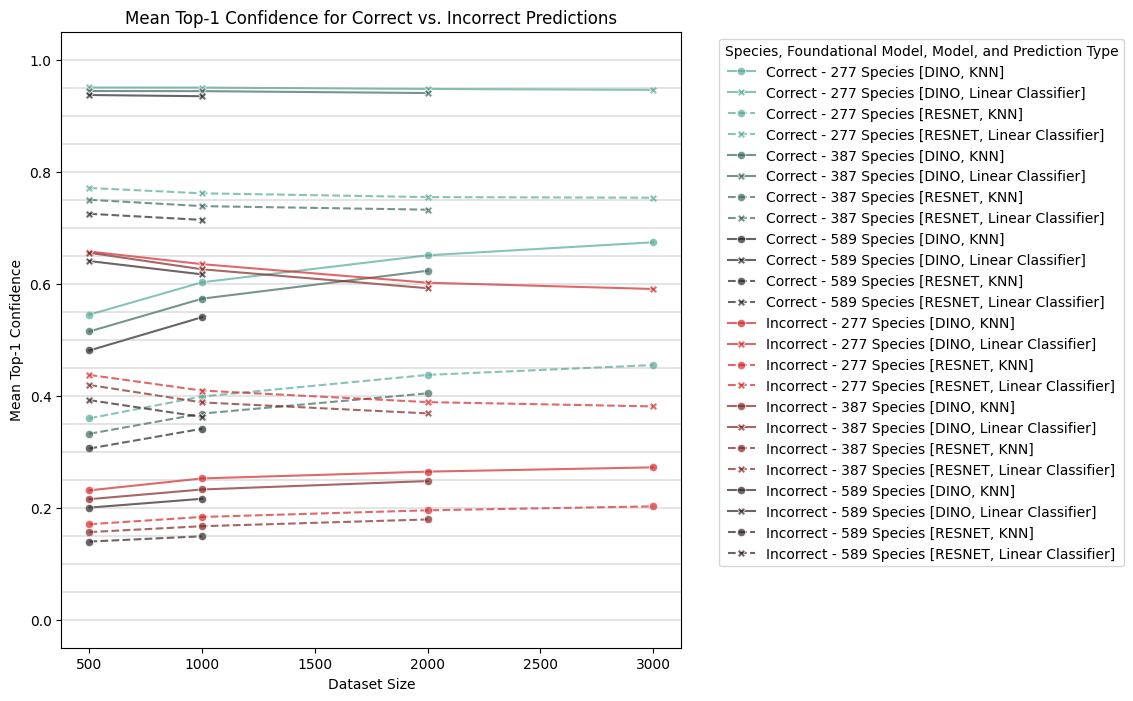

In [11]:
# Add a column to indicate whether the prediction is correct
confidences_csv['Correct'] = confidences_csv['Label'] == confidences_csv['PredictedLabel']

# Compute mean Top-1 confidence for correct and incorrect classifications
mean_confidence_correct = confidences_csv[confidences_csv['Correct']].groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Top1_Confidence'].mean().reset_index()
mean_confidence_incorrect = confidences_csv[~confidences_csv['Correct']].groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Top1_Confidence'].mean().reset_index()

# Merge the results into a single DataFrame for plotting
mean_confidence_correct['Type'] = 'Correct'
mean_confidence_incorrect['Type'] = 'Incorrect'
mean_confidence_combined = pd.concat([mean_confidence_correct, mean_confidence_incorrect])

# Define markers and linestyles for each combination of foundational model and model
markers = {
    ('dino', 'KNN'): ('o', '-'),
    ('dino', 'Linear Classifier'): ('X', '-'),
    ('resnet', 'KNN'): ('o', '--'),
    ('resnet', 'Linear Classifier'): ('X', '--')
}

# Define darker color palettes for correct (dark green) and incorrect (dark red) predictions
correct_palette = sns.color_palette("dark:#5A9_r", len(mean_confidence_combined['Species'].unique()))
incorrect_palette = sns.color_palette("dark:#D62728_r", len(mean_confidence_combined['Species'].unique()))

# Create a dictionary to store colors for each species and type
species_colors = {}
for i, species in enumerate(mean_confidence_combined['Species'].unique()):
    species_colors[(species, 'Correct')] = correct_palette[i % len(correct_palette)]
    species_colors[(species, 'Incorrect')] = incorrect_palette[i % len(incorrect_palette)]

# Plot the mean Top-1 confidence for correct and incorrect classifications against dataset size
plt.figure(figsize=(8, 8))
for prediction_type in ['Correct', 'Incorrect']:
    for species in mean_confidence_combined['Species'].unique():
        for (fm, model), (marker, linestyle) in markers.items():
            species_subset = mean_confidence_combined[(mean_confidence_combined['FoundationalModel'] == fm) & 
                                                      (mean_confidence_combined['Model'] == model) & 
                                                      (mean_confidence_combined['Species'] == species) & 
                                                      (mean_confidence_combined['Type'] == prediction_type)]
            label = f"{prediction_type} - {species} Species [{fm.upper()}, {model}]"
            sns.lineplot(x='Samples', y='Top1_Confidence', data=species_subset, marker=marker, linestyle=linestyle, 
                         color=species_colors[(species, prediction_type)], alpha=0.7, label=label)

# Add horizontal lines
for y in range(0, 101, 5):
    plt.axhline(y=y/100, color='gray', linestyle='-', linewidth=0.3)
    
plt.title('Mean Top-1 Confidence for Correct vs. Incorrect Predictions')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Top-1 Confidence')
plt.legend(title='Species, Foundational Model, Model, and Prediction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Mean Confidence Gap Between Top-1 and Top-2 Predictions
Measures model uncertainty

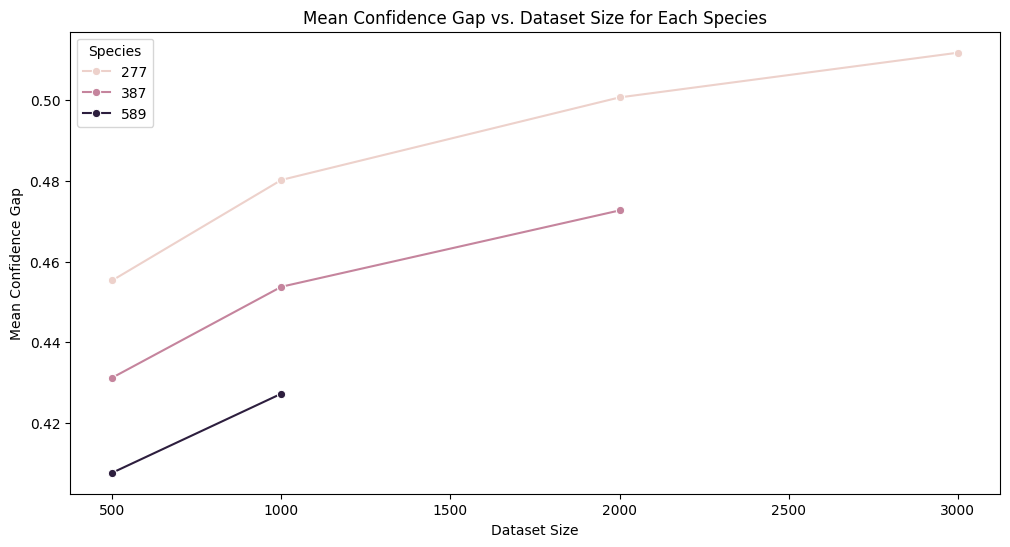

Species  Samples  Confidence_Gap
0      277     3000        0.511736
1      277     2000        0.500665
2      277     1000        0.480211
3      387     2000        0.472657
4      277      500        0.455324
5      387     1000        0.453744
6      387      500        0.431220
7      589     1000        0.427253
8      589      500        0.407659

In [12]:

# Compute the mean confidence gap for each species and sample size
mean_confidence_gap = confidences_csv.groupby(['Species', 'Samples'])['Confidence_Gap'].mean().reset_index()

# Plot species and sample size vs. mean confidence gap
plt.figure(figsize=(12, 6))
sns.lineplot(x='Samples', y='Confidence_Gap', hue='Species', data=mean_confidence_gap, marker='o')
plt.title('Mean Confidence Gap vs. Dataset Size for Each Species')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Confidence Gap')
plt.legend(title='Species')
plt.show()

mean_confidence_gap.sort_values(by='Confidence_Gap', ascending=False).reset_index(drop=True)

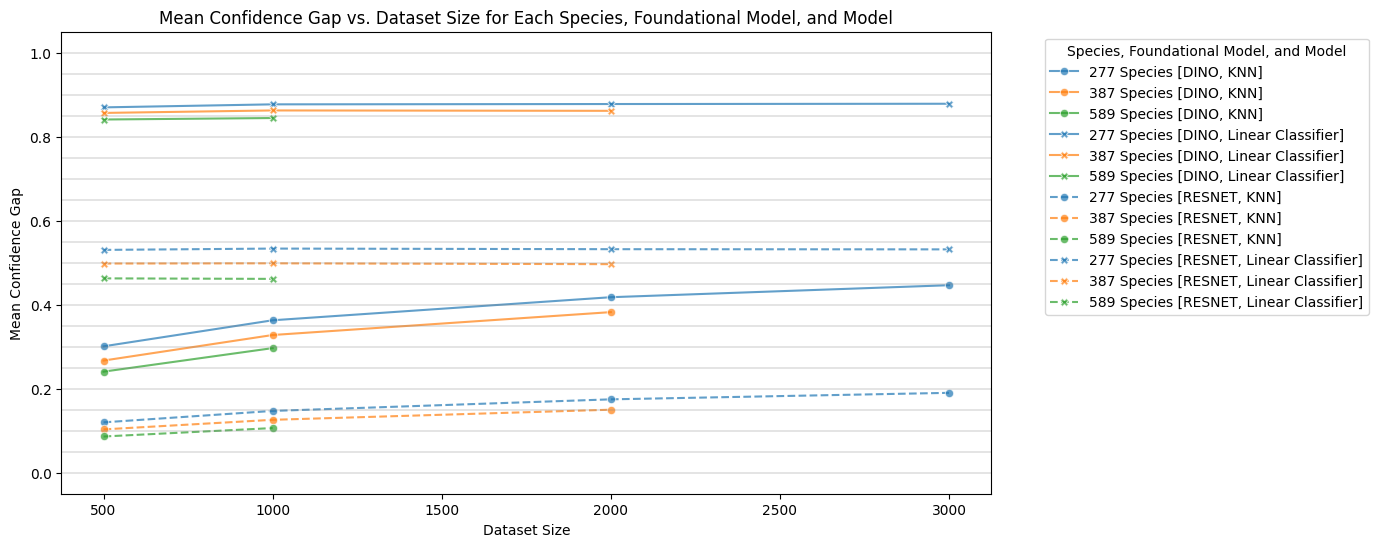

Species  Samples FoundationalModel              Model  Confidence_Gap
0       277     3000              dino  Linear Classifier        0.878506
1       277     2000              dino  Linear Classifier        0.877842
2       277     1000              dino  Linear Classifier        0.877084
3       277      500              dino  Linear Classifier        0.869872
4       387     1000              dino  Linear Classifier        0.862573
5       387     2000              dino  Linear Classifier        0.861661
6       387      500              dino  Linear Classifier        0.856655
7       589     1000              dino  Linear Classifier        0.844483
8       589      500              dino  Linear Classifier        0.840997
9       277     1000            resnet  Linear Classifier        0.533673
10      277     2000            resnet  Linear Classifier        0.532227
11      277     3000            resnet  Linear Classifier        0.531789
12      277      500            resnet  Linear Classifier        0.530544
13      387     1000            resnet  Linear Classifier        0.498551
14      387      500            resnet  Linear Classifier        0.498040
15      387     2000            resnet  Linear Classifier        0.496547
16      589      500            resnet  Linear Classifier        0.462736
17      589     1000            resnet  Linear Classifier        0.461521
18      277     3000              dino                KNN        0.446454
19      277     2000              dino                KNN        0.417890
20      387     2000              dino                KNN        0.382374
21      277     1000              dino                KNN        0.362949
22      387     1000              dino                KNN        0.327879
23      277      500              dino                KNN        0.300946
24      589     1000              dino                KNN        0.296679
25      387      500              dino                KNN        0.267045
26      589      500              dino                KNN        0.240654
27      277     3000            resnet                KNN        0.190195
28      277     2000            resnet                KNN        0.174701
29      387     2000            resnet                KNN        0.150047
30      277     1000            resnet                KNN        0.147138
31      387     1000            resnet                KNN        0.125973
32      277      500            resnet                KNN        0.119934
33      589     1000            resnet                KNN        0.106328
34      387      500            resnet                KNN        0.103142
35      589      500            resnet                KNN        0.086249

In [13]:
import warnings

warnings.filterwarnings('ignore')

mean_confidence_gap = confidences_csv.groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Confidence_Gap'].mean().reset_index()

# Define markers for each combination of foundational model and model
markers = {
    ('dino', 'KNN'): ('o', '-'),
    ('dino', 'Linear Classifier'): ('X', '-'),
    ('resnet', 'KNN'): ('o','--'),
    ('resnet', 'Linear Classifier'): ('X', '--')
}

# Define a high contrast color palette
palette = sns.color_palette("tab10")

# Create a dictionary to store colors for each species
species_colors = {species: palette[i % len(palette)] for i, species in enumerate(mean_confidence_gap['Species'].unique())}

# Plot species, sample size, foundational model, and model vs. mean confidence gap
plt.figure(figsize=(12, 6))
for (fm, model), (marker, linestyle) in markers.items():
    subset = mean_confidence_gap[(mean_confidence_gap['FoundationalModel'] == fm) & (mean_confidence_gap['Model'] == model)]
    for species in subset['Species'].unique():
        species_subset = subset[subset['Species'] == species]
        label = f"{species} Species [{fm.upper()}, {model}]"
        sns.lineplot(x='Samples', y='Confidence_Gap', data=species_subset, marker=marker, linestyle=linestyle, color=species_colors[species], alpha=0.7, label=label)

# Add horizontal lines
for y in range(0, 101, 5):
    plt.axhline(y=y/100, color='gray', linestyle='-', linewidth=0.3)

plt.title('Mean Confidence Gap vs. Dataset Size for Each Species, Foundational Model, and Model')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Confidence Gap')
plt.legend(title='Species, Foundational Model, and Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

mean_confidence_gap.sort_values(by='Confidence_Gap', ascending=False).reset_index(drop=True)

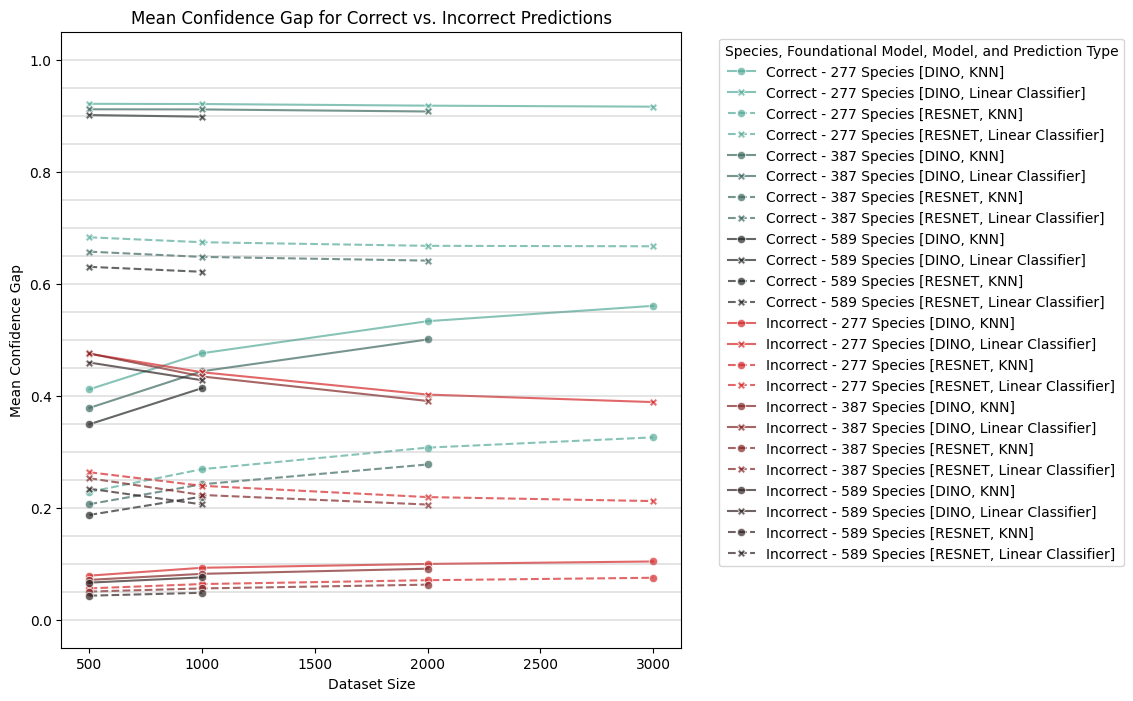

In [14]:
# Compute mean confidence gap for correct and incorrect classifications
mean_confidence_gap_correct = confidences_csv[confidences_csv['Correct']].groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Confidence_Gap'].mean().reset_index()
mean_confidence_gap_incorrect = confidences_csv[~confidences_csv['Correct']].groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Confidence_Gap'].mean().reset_index()

# Merge the results into a single DataFrame for plotting
mean_confidence_gap_correct['Type'] = 'Correct'
mean_confidence_gap_incorrect['Type'] = 'Incorrect'
mean_confidence_gap_combined = pd.concat([mean_confidence_gap_correct, mean_confidence_gap_incorrect])

# Define markers and linestyles for each combination of foundational model and model
markers = {
    ('dino', 'KNN'): ('o', '-'),
    ('dino', 'Linear Classifier'): ('X', '-'),
    ('resnet', 'KNN'): ('o', '--'),
    ('resnet', 'Linear Classifier'): ('X', '--')
}

# Define darker color palettes for correct (dark green) and incorrect (dark red) predictions
correct_palette = sns.color_palette("dark:#5A9_r", len(mean_confidence_gap_combined['Species'].unique()))
incorrect_palette = sns.color_palette("dark:#D62728_r", len(mean_confidence_gap_combined['Species'].unique()))

# Create a dictionary to store colors for each species and type
species_colors = {}
for i, species in enumerate(mean_confidence_gap_combined['Species'].unique()):
    species_colors[(species, 'Correct')] = correct_palette[i % len(correct_palette)]
    species_colors[(species, 'Incorrect')] = incorrect_palette[i % len(incorrect_palette)]

# Plot the mean confidence gap for correct and incorrect classifications against dataset size
plt.figure(figsize=(8, 8))
for prediction_type in ['Correct', 'Incorrect']:
    for species in mean_confidence_gap_combined['Species'].unique():
        for (fm, model), (marker, linestyle) in markers.items():
            species_subset = mean_confidence_gap_combined[(mean_confidence_gap_combined['FoundationalModel'] == fm) & 
                                                          (mean_confidence_gap_combined['Model'] == model) & 
                                                          (mean_confidence_gap_combined['Species'] == species) & 
                                                          (mean_confidence_gap_combined['Type'] == prediction_type)]
            label = f"{prediction_type} - {species} Species [{fm.upper()}, {model}]"
            sns.lineplot(x='Samples', y='Confidence_Gap', data=species_subset, marker=marker, linestyle=linestyle, 
                         color=species_colors[(species, prediction_type)], alpha=0.7, label=label)

# Add horizontal lines
for y in range(0, 101, 5):
    plt.axhline(y=y/100, color='gray', linestyle='-', linewidth=0.3)
    
plt.title('Mean Confidence Gap for Correct vs. Incorrect Predictions')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Confidence Gap')
plt.legend(title='Species, Foundational Model, Model, and Prediction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### 4. Confidence Variability Across Dataset Sizes
Checks if models become more stable with more data.

Compute the standard deviation of Top-1 confidences across all samples for each dataset size.
Plot dataset size vs. confidence standard deviation.

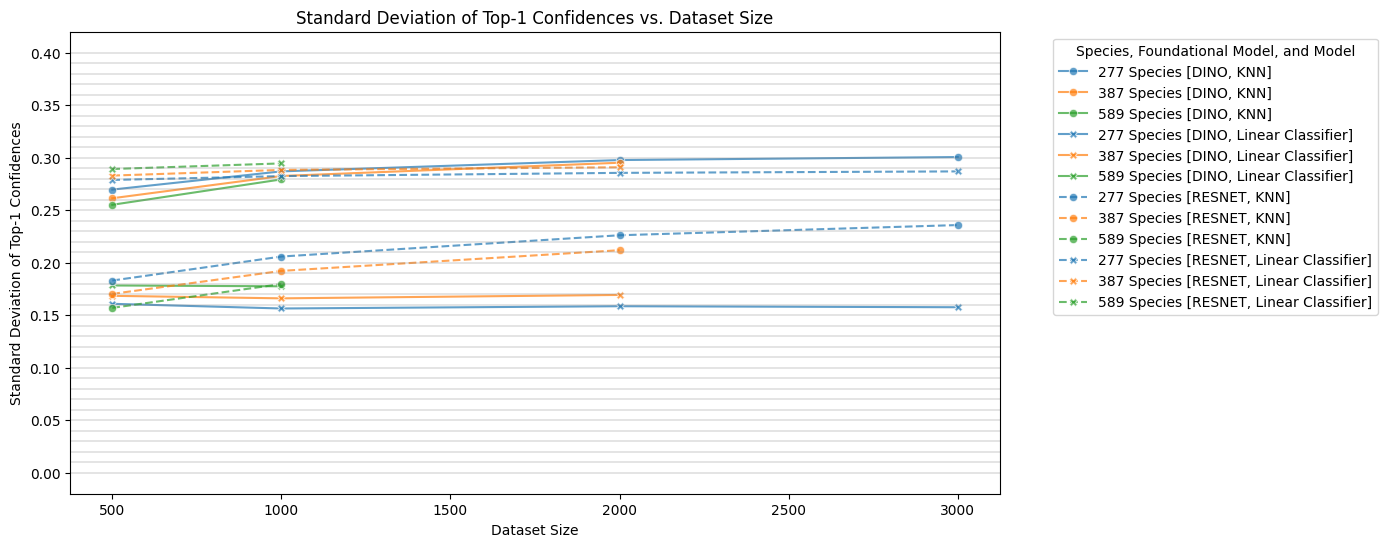

In [18]:
# Compute the standard deviation of Top-1 confidences for each dataset size, species, foundational model, and model
std_top1_confidences = confidences_csv.groupby(['Species', 'Samples', 'FoundationalModel', 'Model'])['Top1_Confidence'].std().reset_index()

# Define markers for each combination of foundational model and model
markers = {
    ('dino', 'KNN'): ('o', '-'),
    ('dino', 'Linear Classifier'): ('X', '-'),
    ('resnet', 'KNN'): ('o', '--'),
    ('resnet', 'Linear Classifier'): ('X', '--')
}

# Define a high contrast color palette
palette = sns.color_palette("tab10")

# Create a dictionary to store colors for each species
species_colors = {species: palette[i % len(palette)] for i, species in enumerate(std_top1_confidences['Species'].unique())}

# Plot dataset size, species, foundational model, and model vs. confidence standard deviation
plt.figure(figsize=(12, 6))
for (fm, model), (marker, linestyle) in markers.items():
    subset = std_top1_confidences[(std_top1_confidences['FoundationalModel'] == fm) & (std_top1_confidences['Model'] == model)]
    for species in subset['Species'].unique():
        species_subset = subset[subset['Species'] == species]
        label = f"{species} Species [{fm.upper()}, {model}]"
        sns.lineplot(x='Samples', y='Top1_Confidence', data=species_subset, marker=marker, linestyle=linestyle, color=species_colors[species], alpha=0.7, label=label)

# Add horizontal lines
for y in range(0, 41, 1):
    plt.axhline(y=y/100, color='gray', linestyle='-', linewidth=0.3)

plt.title('Standard Deviation of Top-1 Confidences vs. Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Standard Deviation of Top-1 Confidences')
plt.legend(title='Species, Foundational Model, and Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Class-Specific Confidence Trends ???????????????????
Identify species that remain hard to classify even with more data.

Select 5-10 classes with the lowest confidence and see if their confidence improves with dataset size.
Some species might remain difficult regardless of dataset size, showing potential dataset bias.

In [21]:
confidences_csv.head(5)

Species  Samples FoundationalModel              Model  Training Time (s)  \
0      277     3000            resnet  Linear Classifier             103.69   
1      277     3000            resnet  Linear Classifier             103.69   
2      277     3000            resnet  Linear Classifier             103.69   
3      277     3000            resnet  Linear Classifier             103.69   
4      277     3000            resnet  Linear Classifier             103.69   

   Accuracy  Precision  Recall  F1-Score      GbifID  Label  PredictedLabel  \
0    0.7031     0.7023  0.7031     0.702  3732729294      2             481   
1    0.7031     0.7023  0.7031     0.702  3726074650      2               2   
2    0.7031     0.7023  0.7031     0.702  3722145058      2               2   
3    0.7031     0.7023  0.7031     0.702  3732212583      2             459   
4    0.7031     0.7023  0.7031     0.702  3721997113      2               2   

                                          Confidence  Top1_Confidence  \
0  [(481, 0.5774608), (78, 0.18059804), (70, 0.03...         0.577461   
1  [(2, 0.8209467), (577, 0.040576253), (90, 0.02...         0.820947   
2  [(2, 0.9660788), (415, 0.016777342), (185, 0.0...         0.966079   
3  [(459, 0.6787469), (577, 0.15710153), (90, 0.0...         0.678747   
4  [(2, 0.57313013), (185, 0.060512815), (184, 0....         0.573130   

   Top2_Confidence  Confidence_Gap  Correct  
0         0.180598        0.396863    False  
1         0.040576        0.780370     True  
2         0.016777        0.949301     True  
3         0.157102        0.521645    False  
4         0.060513        0.512617     True

### Find out ambiguous classes

In [24]:
# class accuracies

class_accuracies = confidences_csv.groupby('Label')['Correct'].mean().sort_values().reset_index()
class_accuracies.head(10)

Label   Correct
0    256  0.230000
1    486  0.291975
2    475  0.299891
3    166  0.301667
4    502  0.343333
5     99  0.344167
6    573  0.355000
7    271  0.355000
8    330  0.358333
9     56  0.361667

In [41]:
# Analysis of worst class, 7% drop in accuracy to second worst for class 256

class_to_analyze = 256

wrong_predictions = confidences_csv[(confidences_csv['Label'] == class_to_analyze) & (confidences_csv['Correct'] == False)]['PredictedLabel'].value_counts().sort_values(ascending=False).reset_index()
print(wrong_predictions.head(10))

   PredictedLabel  count
0             255    216
1             258     75
2             259     75
3             250     70
4             253     58
5             252     46
6             257     33
7             287     24
8             254     20
9             330     16


Actual species:


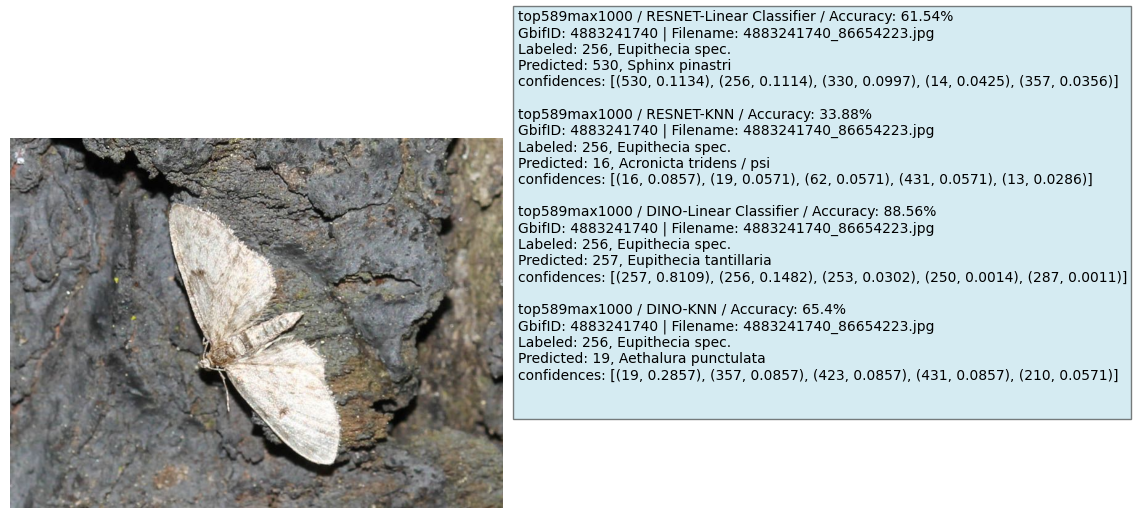



Wrong predictions:


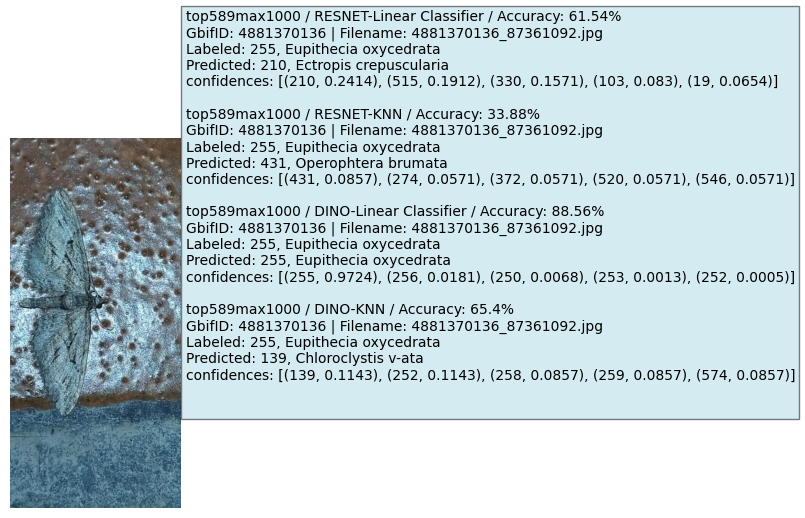

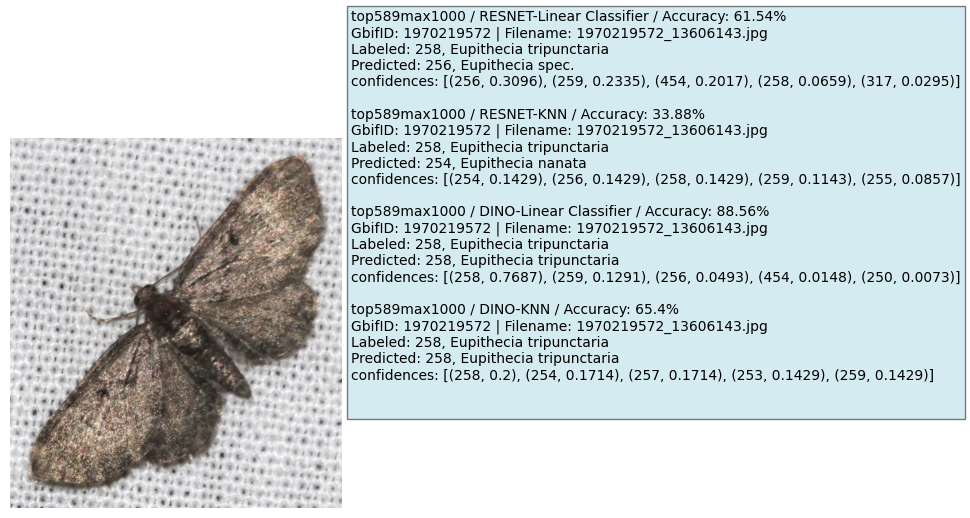

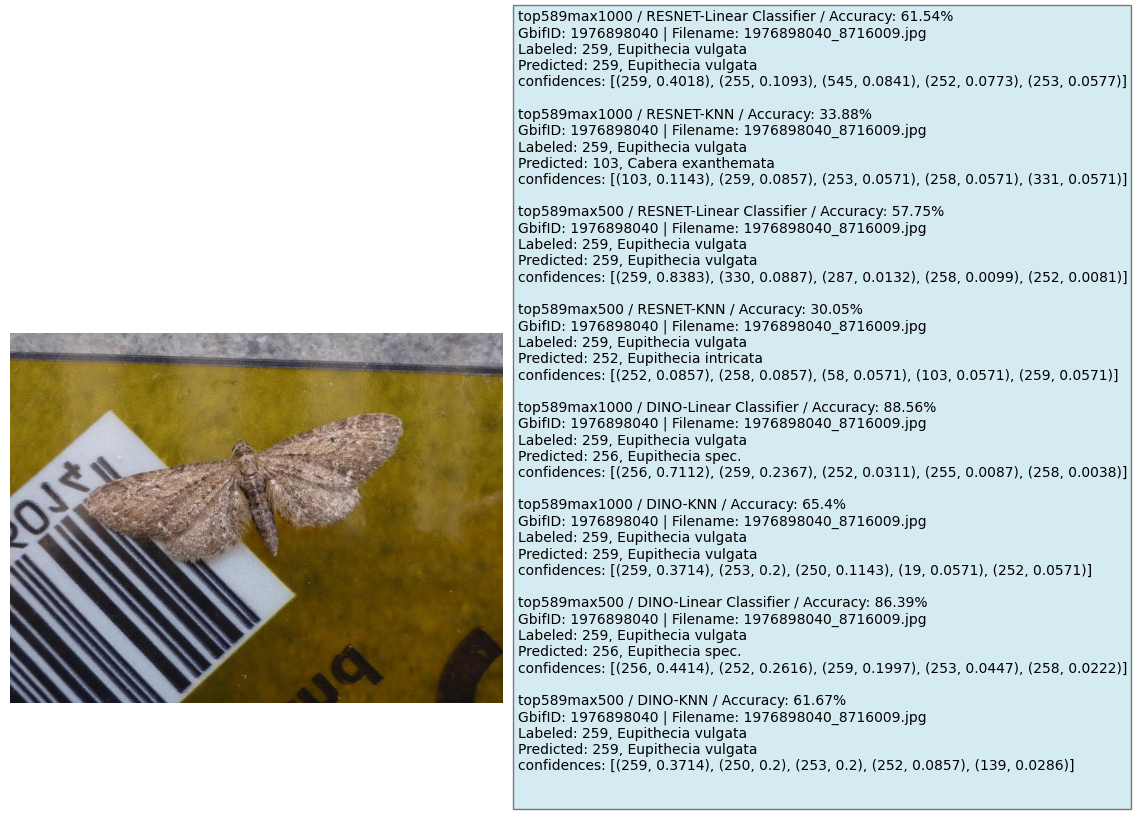

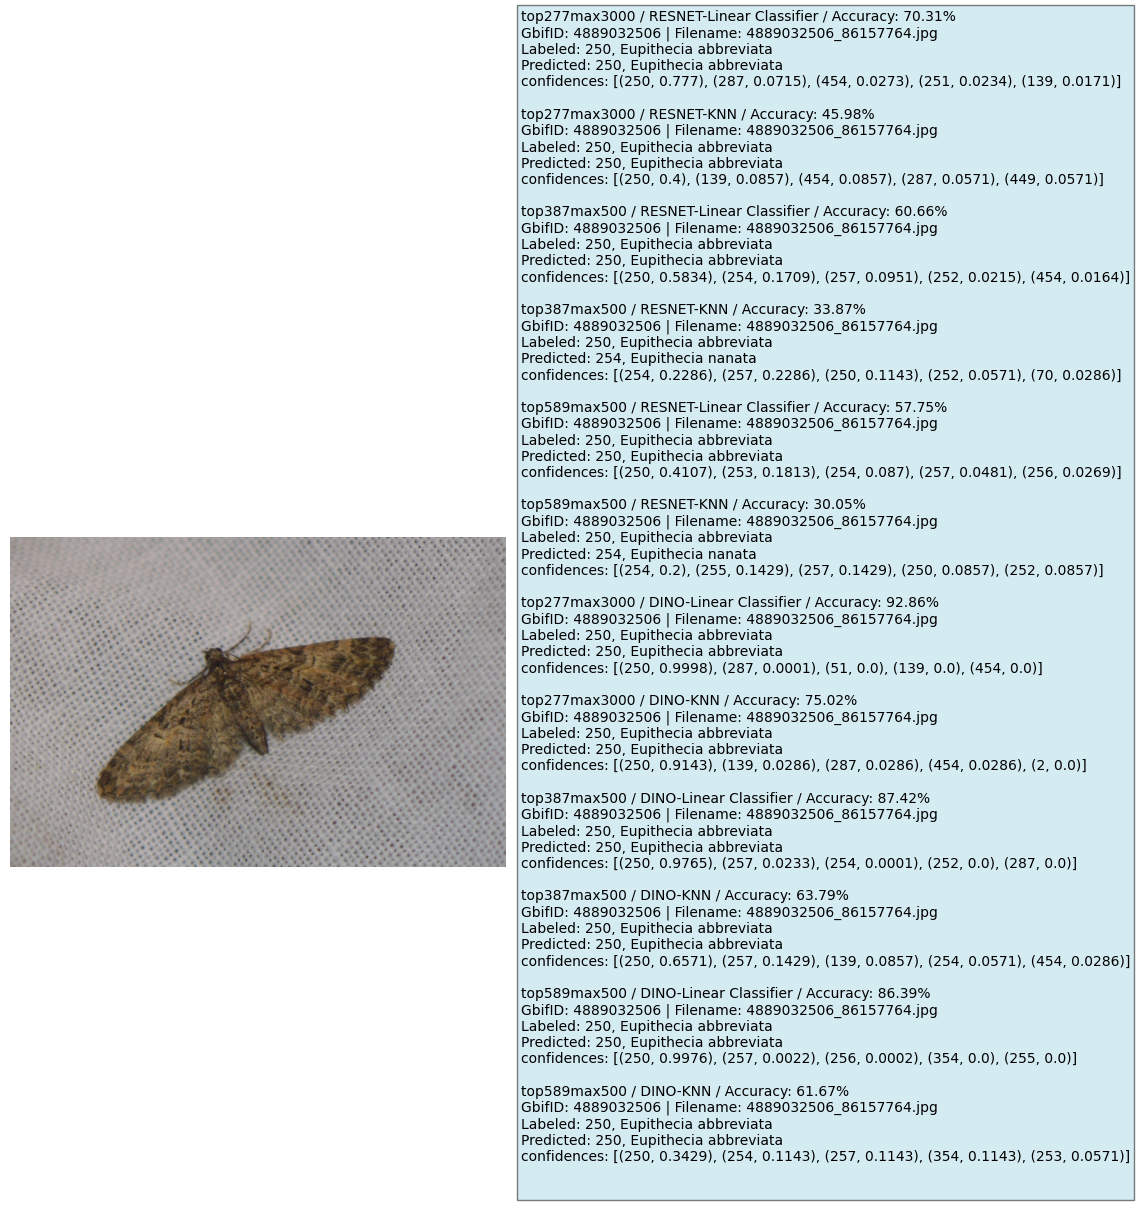

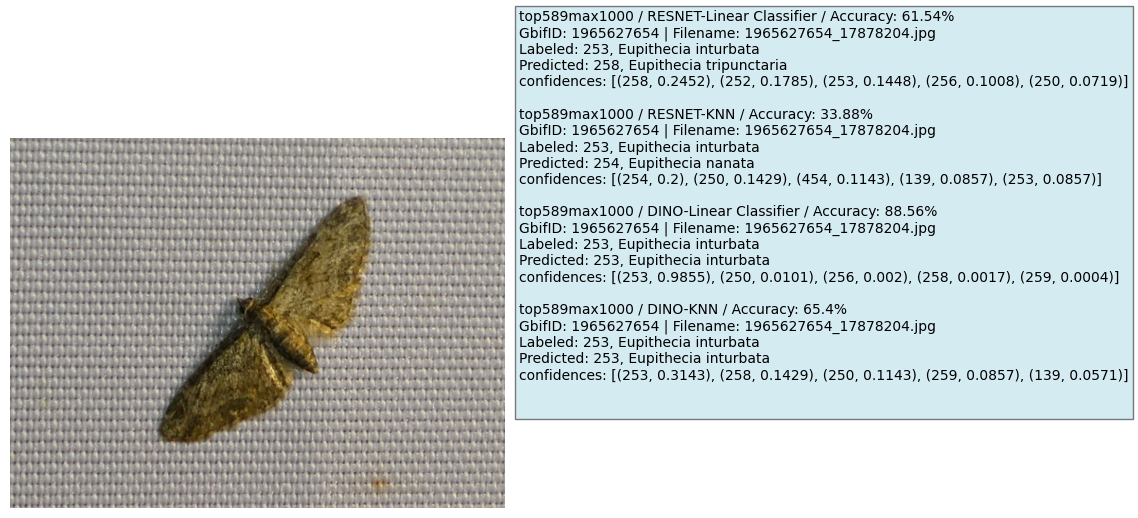

In [45]:
print('Actual species:')
gbifid_example = get_gbifids_for_class(class_to_analyze, confidences_csv)
show_sample_by_id(gbifid_example[0], confidences_csv)


top5prediction_failures = list(wrong_predictions['PredictedLabel'])[0:5]

print('\n\nWrong predictions:')
for f in top5prediction_failures:
    gbifid_example = get_gbifids_for_class(f, confidences_csv)
    show_sample_by_id(gbifid_example[0], confidences_csv)


In [ ]:



mean_confidence_per_species = confidences_csv.groupby('Species','Samples','Label')['Top1_Confidence'].mean().sort_values().reset_index()
mean_confidence_per_species



ValueError: No axis named Samples for object type DataFrame

In [16]:
# Calculate the mean Top-1 confidence for each species
mean_confidence_per_species = confidences_csv.groupby('Species','Samples','Label')['Top1_Confidence'].mean().sort_values().reset_index()

# Select the 10 species with the lowest mean Top-1 confidence
lowest_confidence_species = mean_confidence_per_species.head(10)['Label']

# Filter the dataframe to include only the selected species
filtered_confidences_csv = confidences_csv[confidences_csv['Label'].isin(lowest_confidence_species)]

# Calculate the mean Top-1 confidence for the selected species across different dataset sizes
mean_confidence_trends = filtered_confidences_csv.groupby('Label')['Top1_Confidence'].mean().reset_index()

# Plot the mean Top-1 confidence for the selected species against dataset size
plt.figure(figsize=(12, 6))
sns.lineplot(x='Samples', y='Top1_Confidence', hue='Label', data=mean_confidence_trends, marker='o')
plt.title('Mean Top-1 Confidence for Species with Lowest Confidence')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Top-1 Confidence')
plt.legend(title='Species')
plt.show()

ValueError: Could not interpret value `Samples` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>




### Tests
- average highest confidences at different classes for different fm models and classifiers
- average confidences for correct predictions and wrong predictions

- compare IDENTICAL samples across multiple variations
- means:
    - mean confidence values of samples that have the same dataset config to estimate DATASET-IMPACT performance



- find out which often get confused
- analyze specific samples which are representative?
- what does it say when the second choice would have been right and both have a sall difference